# Interictal Spikes Analysis

In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes/"
SEIZURES_DIR = "../../Data/seizures/source_mat/"
SEIZURE_BUFFER_TIME = 5  # hours

In [2]:
patient_hup_id = 143
fs = 1024
# Calculate the buffer time in samples
buffer_samples = SEIZURE_BUFFER_TIME * 3600 * fs

In [3]:
seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{patient_hup_id}.npy"))
seizure_times_samples = seizure_times_sec * fs
seizure_times_samples = seizure_times_samples.astype(int)
seizure_times_samples

array([[609828311, 609889751],
       [611381135, 611406991],
       [612594739, 612621762],
       [818522163, 818576076]])

In [4]:
# Initialize an empty list to hold the data
data = []

# Iterate through all files in the directory
for filename in os.listdir(SPIKES_OUTPUT_DIR):
    # Check if the file ends with .npy
    if filename.endswith(".npy"):
        # Use regular expression to match the pattern and extract desired numbers
        match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

        if match:
            current_patient_hup_id = int(match.group(1))
            if current_patient_hup_id != patient_hup_id:
                continue
            interval_index = int(match.group(2))

            # Append the data to the list
            data.append(
                {
                    "filename": filename,
                    "interval_index": interval_index,
                }
            )

# Convert the list of dictionaries to a pandas DataFrame
spike_files_df = pd.DataFrame(data)
# Sort the DataFrame by the interval index
spike_files_df = spike_files_df.sort_values(by="interval_index")
# Reset the index
spike_files_df = spike_files_df.reset_index(drop=True)
# Add a new column called "start_sample_index"
spike_files_df["start_sample_index"] = spike_files_df["interval_index"] * fs * 60 * 2
spike_files_df

,filename,interval_index,start_sample_index
0,HUP143_phaseII_150.npy,150,18432000
1,HUP143_phaseII_156.npy,156,19169280
2,HUP143_phaseII_157.npy,157,19292160
3,HUP143_phaseII_158.npy,158,19415040
4,HUP143_phaseII_159.npy,159,19537920
...,...,...,...
6694,HUP143_phaseII_7163.npy,7163,880189440
6695,HUP143_phaseII_7164.npy,7164,880312320
6696,HUP143_phaseII_7165.npy,7165,880435200
6697,HUP143_phaseII_7166.npy,7166,880558080


In [5]:
# Initialize an empty list to store individual DataFrames
dfs = []

for index, row in spike_files_df.iterrows():
    filename = row["filename"]
    start_sample_index = row["start_sample_index"]

    # Load the data
    spike_data = np.load(os.path.join(SPIKES_OUTPUT_DIR, filename))

    # Convert all values to int
    spike_data = spike_data.astype(int)

    # Adjust the start_sample_index
    spike_data[:, 0] += start_sample_index

    # Convert the modified spike_data to a DataFrame and append to the dfs list
    dfs.append(
        pd.DataFrame(
            spike_data,
            columns=["peak_index", "channel_index", "sequence_index"],
        )
    )

# Concatenate all the individual DataFrames into a single DataFrame
all_spikes_df = pd.concat(dfs, ignore_index=True)

all_spikes_df

,peak_index,channel_index,sequence_index
0,18463258,0,0
1,18463258,2,0
2,18463258,1,0
3,18500815,0,1
4,18500815,2,1
...,...,...,...
288922,880797717,2,52
288923,880798082,0,53
288924,880798085,1,53
288925,880802131,1,54


In [6]:
# # Create a mask to determine which rows to keep
# mask = np.ones(len(all_spikes_df), dtype=bool)
# for start, end in seizure_times_samples:
#     mask &= ~(
#         (all_spikes_df["peak_index"] >= start - buffer_samples)
#         & (all_spikes_df["peak_index"] <= end + buffer_samples)
#     )

# # Use the mask to filter rows
# interictal_spikes_df = all_spikes_df.copy()[mask]

# # reset index
# interictal_spikes_df.reset_index(drop=True, inplace=True)

# interictal_spikes_df

## Raster plot

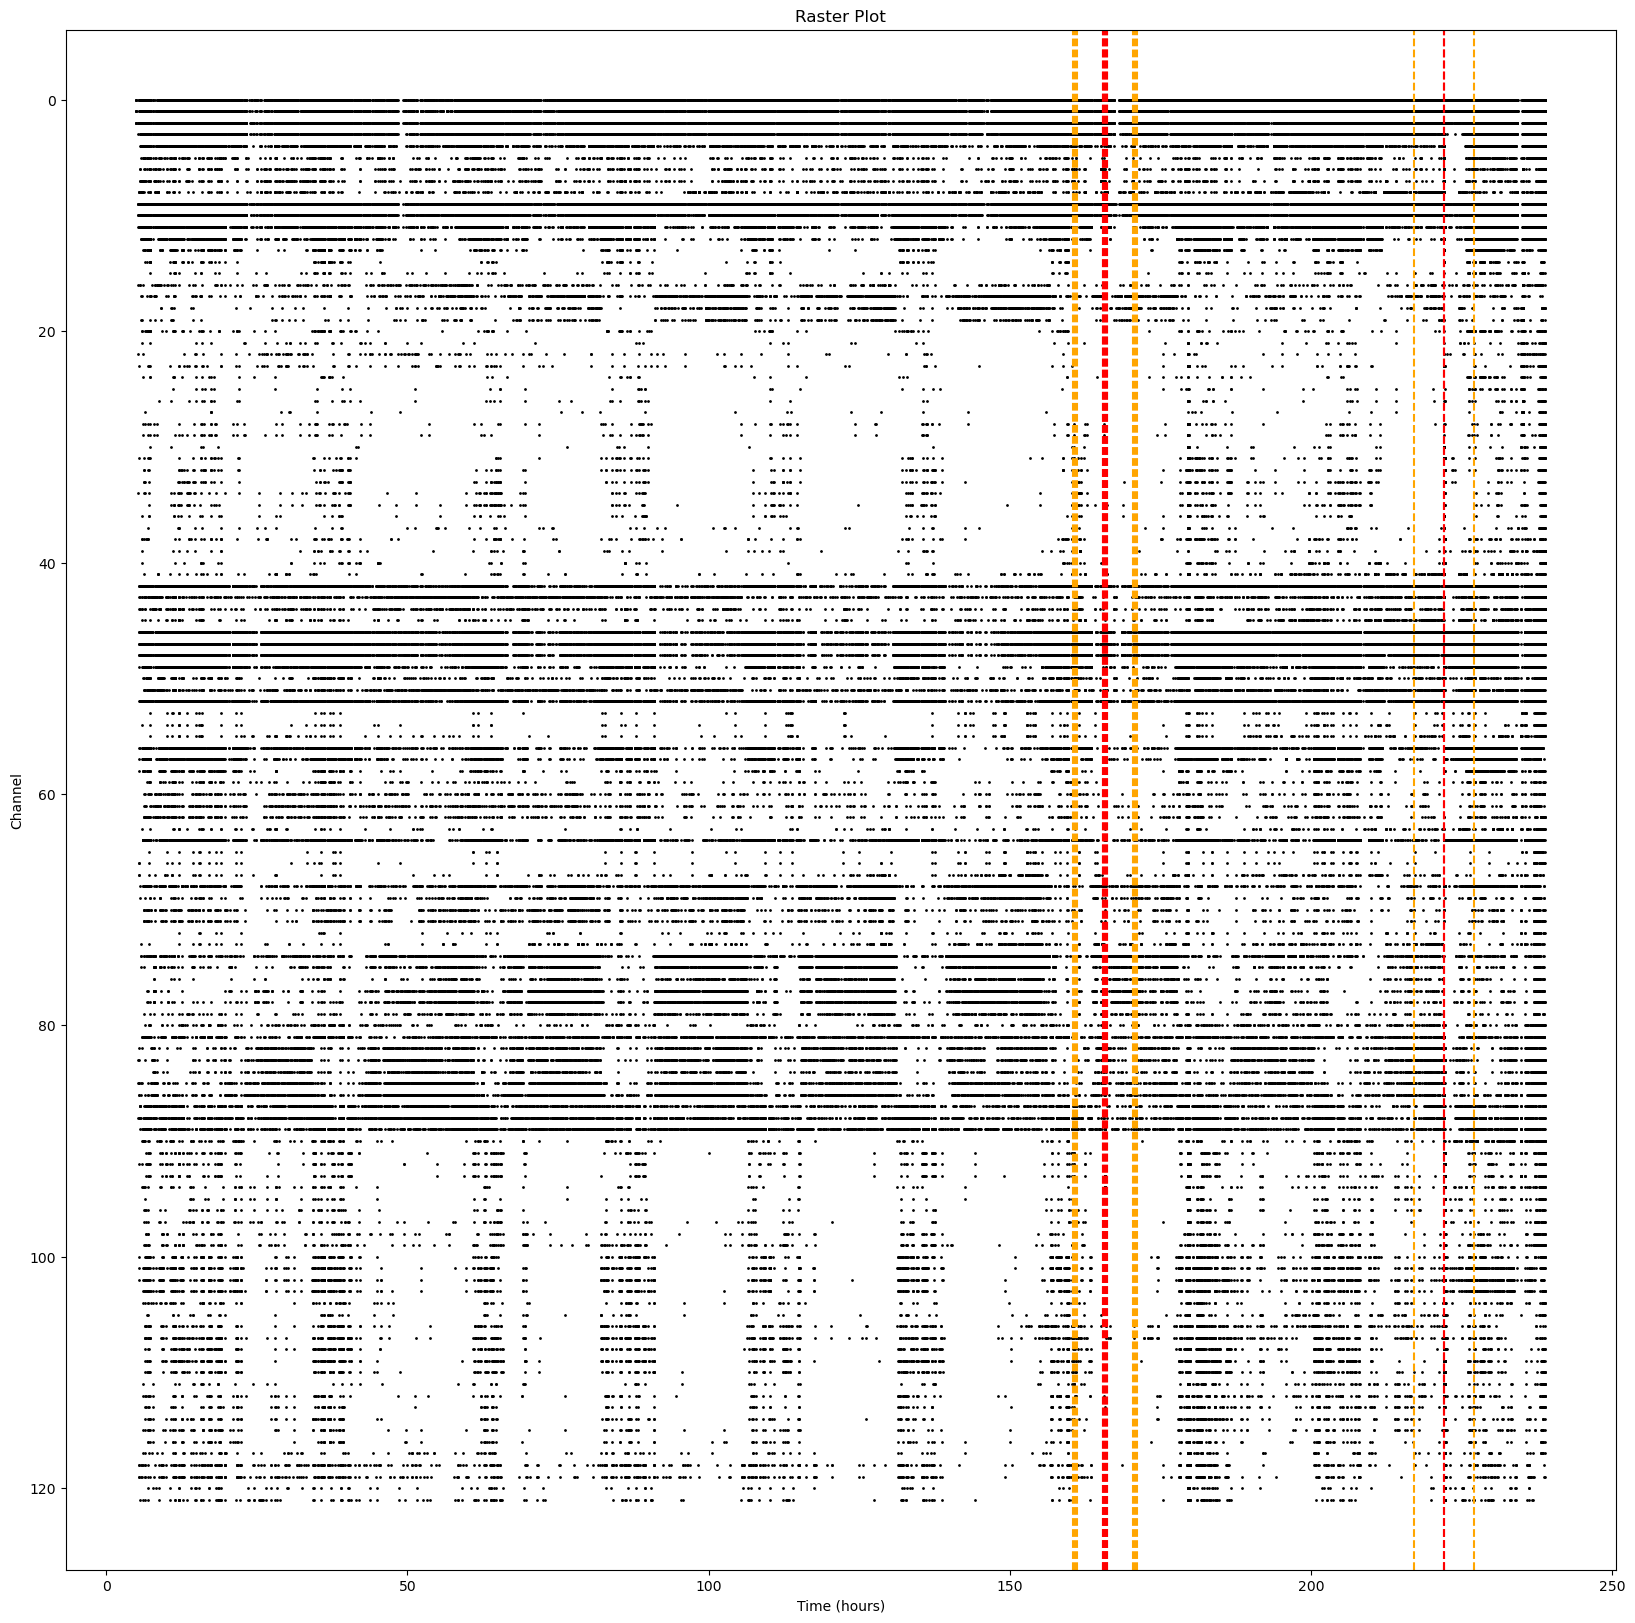

In [7]:
def raster_plot(df, seizure_times, buffer_samples, fs):
    fig, ax = plt.subplots(figsize=(20, 20))
    # Iterate through unique channels
    for channel in df["channel_index"].unique():
        # Extract spike times for this channel
        spike_times = df[df["channel_index"] == channel]["peak_index"]
        spike_times_in_hours = spike_times / (fs * 3600)  # Convert to hours
        ax.plot(spike_times_in_hours, [channel] * len(spike_times), "k.", markersize=2)

    # Plot vertical dashed lines for seizure times
    for start, end in seizure_times:
        ax.axvline(start / (fs * 3600), color="r", linestyle="--")
        ax.axvline(end / (fs * 3600), color="r", linestyle="--")

    # Plot vertical dashed lines for seizure times with buffer
    for start, end in seizure_times:
        ax.axvline(
            (start - buffer_samples) / (fs * 3600), color="orange", linestyle="--"
        )
        ax.axvline((end + buffer_samples) / (fs * 3600), color="orange", linestyle="--")

    ax.set_ylabel("Channel")
    ax.set_xlabel("Time (hours)")
    ax.set_title("Raster Plot")
    ax.invert_yaxis()  # Optional: to have channel 0 at the top
    plt.show()


raster_plot(all_spikes_df, seizure_times_samples, buffer_samples, fs)

## Inter-spike intervals (ISI)

In [8]:
# Calculate the inter-spike interval
all_spikes_df["inter_spike_interval_samples"] = all_spikes_df["peak_index"].diff()

# If you want to handle the NaN value for the first row (since there's no previous spike to compare to):
all_spikes_df.loc[0, "inter_spike_interval_samples"] = 0  # or any other suitable value

# Convert the inter_spike_interval_samples column to integer
all_spikes_df["inter_spike_interval_samples"] = all_spikes_df[
    "inter_spike_interval_samples"
].astype(int)

all_spikes_df["inter_spike_interval_sec"] = (
    all_spikes_df["inter_spike_interval_samples"] / fs
).astype(int)

all_spikes_df

,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_sec
0,18463258,0,0,0,0
1,18463258,2,0,0,0
2,18463258,1,0,0,0
3,18500815,0,1,37557,36
4,18500815,2,1,0,0
...,...,...,...,...,...
288922,880797717,2,52,74,0
288923,880798082,0,53,365,0
288924,880798085,1,53,3,0
288925,880802131,1,54,4046,3


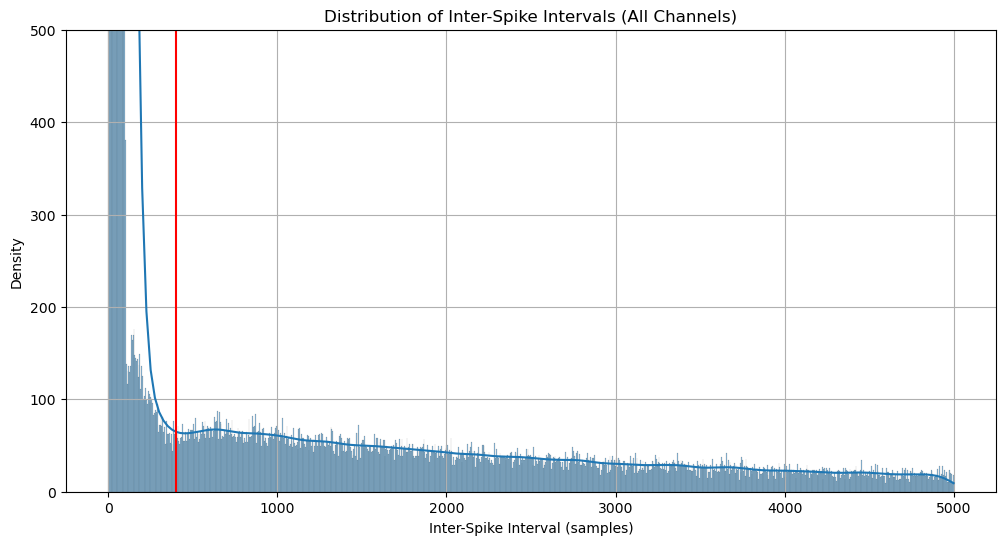

In [9]:
# Create a copy of all_spikes_df called all_spikes_df_copy_2
all_spikes_df_copy_2 = all_spikes_df.copy()

# all_spikes_df_copy_2 = all_spikes_df_copy_2[
#     all_spikes_df_copy_2["inter_spike_interval_samples"] > 100
# ]
all_spikes_df_copy_2 = all_spikes_df_copy_2[
    all_spikes_df_copy_2["inter_spike_interval_samples"] < 5000
]

plt.figure(figsize=(12, 6))
sns.histplot(all_spikes_df_copy_2["inter_spike_interval_samples"], kde=True, bins=1000)
plt.title("Distribution of Inter-Spike Intervals (All Channels)")
plt.xlabel("Inter-Spike Interval (samples)")
plt.ylabel("Density")
# Plot a vertical red line at 500
plt.axvline(x=400, color="red")
# Limit y axis max to 800
plt.ylim(0, 500)
plt.grid(True)
plt.show()

In [10]:
# Convert peak_index to hour
all_spikes_df["hour"] = all_spikes_df["peak_index"] // (fs * 3600)
all_spikes_df.head()

,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_sec,hour
0,18463258,0,0,0,0,5
1,18463258,2,0,0,0,5
2,18463258,1,0,0,0,5
3,18500815,0,1,37557,36,5
4,18500815,2,1,0,0,5


In [11]:
# Check for sequence change based on sequence_index or inter_spike_interval_samples
change_mask = (all_spikes_df["sequence_index"].diff() != 0) | (
    all_spikes_df["inter_spike_interval_samples"] > 400
)

# Create the sequence_index_mask
all_spikes_df["sequence_index_mask"] = change_mask.astype(int).cumsum()

In [12]:
# Identify the first spike in each sequence
first_spikes = all_spikes_df.groupby("sequence_index_mask").first().reset_index()
print("Number of first spikes: ", len(first_spikes))
first_spikes.head(20)

Number of first spikes:  73311


,sequence_index_mask,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_sec,hour
0,1,18463258,0,0,0,0,5
1,2,18500815,0,1,37557,36,5
2,3,18510874,2,2,10059,9,5
3,4,18549988,2,3,39114,38,5
4,5,19200630,2,0,650642,635,5
5,6,19341707,2,0,141046,137,5
6,7,19394884,83,1,53175,51,5
7,8,19461910,88,0,66924,65,5
8,9,19590387,34,0,128420,125,5
9,10,19680227,11,0,89814,87,5


In [13]:
# Filter out the first spikes
filtered_df = pd.concat([all_spikes_df, first_spikes]).drop_duplicates(keep=False)
assert len(filtered_df) == len(all_spikes_df) - len(first_spikes)
filtered_df.head(20)

,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_sec,hour,sequence_index_mask
1,18463258,2,0,0,0,5,1
2,18463258,1,0,0,0,5,1
4,18500815,2,1,0,0,5,2
5,18500815,1,1,0,0,5,2
7,18510874,0,2,0,0,5,3
8,18510874,1,2,0,0,5,3
10,18549988,1,3,0,0,5,4
11,18549988,0,3,0,0,5,4
13,19200631,10,0,1,0,5,5
14,19200633,3,0,2,0,5,5


In [14]:
# Get the columns in filtered_df where hour is 20
filtered_df[filtered_df["hour"] == 20]

,peak_index,channel_index,sequence_index,inter_spike_interval_samples,inter_spike_interval_sec,hour,sequence_index_mask
26381,73867190,88,0,94,0,20,6227
26383,73894714,1,1,49,0,20,6228
26384,73894720,2,1,6,0,20,6228
26386,73894866,85,2,2,0,20,6229
26388,73896840,47,3,35,0,20,6230
...,...,...,...,...,...,...,...
26661,77356991,48,5,0,0,20,6307
26662,77357051,59,5,60,0,20,6307
26663,77357051,60,5,0,0,20,6307
26665,77410856,9,6,10,0,20,6308


In [15]:
# Group by hour to calculate average inter_spike_interval_samples for the same spike train
avg_intervals = (
    filtered_df.groupby("hour")["inter_spike_interval_samples"].mean().reset_index()
)
avg_intervals.head(20)

,hour,inter_spike_interval_samples
0,5,9.084746
1,6,8.125169
2,7,9.005382
3,8,8.995763
4,9,8.554196
5,10,7.747261
6,11,8.716320
7,12,7.972743
8,13,7.387378
9,14,7.482054


In [16]:
# Drop the rows in avg_intervalswhere inter_spike_interval_samples is above 100
avg_intervals = avg_intervals[avg_intervals["inter_spike_interval_samples"] < 20]
avg_intervals.head(20)

,hour,inter_spike_interval_samples
0,5,9.084746
1,6,8.125169
2,7,9.005382
3,8,8.995763
4,9,8.554196
5,10,7.747261
6,11,8.716320
7,12,7.972743
8,13,7.387378
9,14,7.482054


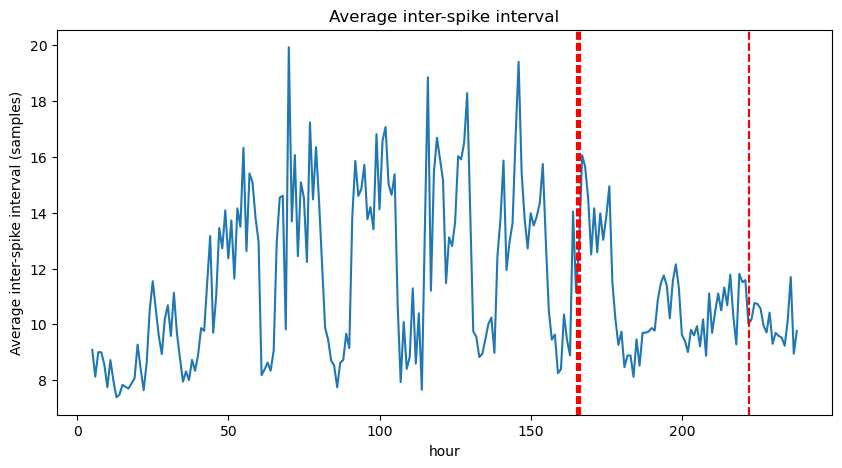

In [17]:
# Plot hour and inter_spike_interval_samples in avg_intervals
plt.plot(avg_intervals["hour"], avg_intervals["inter_spike_interval_samples"])

# Plot vertical lines indicating seizure times
for start, end in seizure_times_samples:
    plt.axvline(start / (fs * 3600), color="r", linestyle="--")
    plt.axvline(end / (fs * 3600), color="r", linestyle="--")

plt.xlabel("hour")
plt.ylabel("Average inter-spike interval (samples)")
plt.title("Average inter-spike interval")

# Make the plot wider
plt.gcf().set_size_inches(10, 5)
plt.show()

In [18]:
# Group by hour to calculate average inter_spike_interval_samples for the same spike train
avg_inter_spike_train_intervals = (
    first_spikes.groupby("hour")["inter_spike_interval_samples"].mean().reset_index()
)
avg_inter_spike_train_intervals.head(20)

,hour,inter_spike_interval_samples
0,5,30797.483051
1,6,5411.632893
2,7,12342.956376
3,8,11640.579114
4,9,6473.703180
5,10,9421.976982
6,11,6940.301136
7,12,6642.877778
8,13,12217.376623
9,14,7232.118577


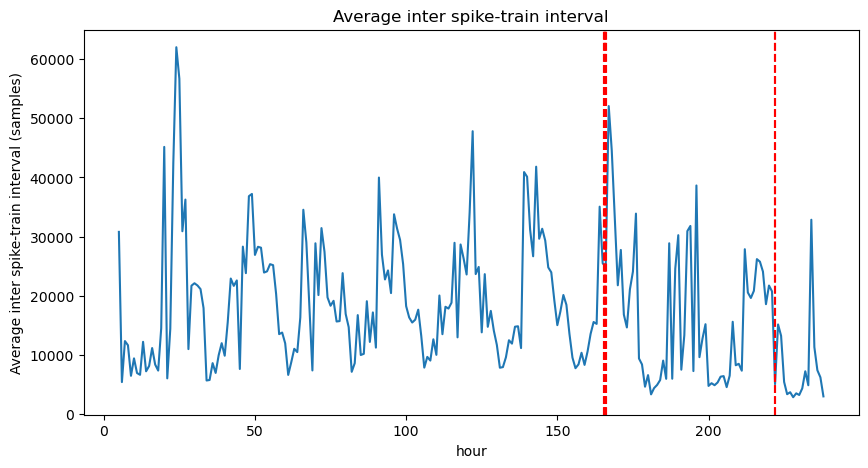

In [19]:
# Plot hour and inter_spike_interval_samples in avg_intervals
plt.plot(
    avg_inter_spike_train_intervals["hour"],
    avg_inter_spike_train_intervals["inter_spike_interval_samples"],
)

# Plot vertical lines indicating seizure times
for start, end in seizure_times_samples:
    plt.axvline(start / (fs * 3600), color="r", linestyle="--")
    plt.axvline(end / (fs * 3600), color="r", linestyle="--")

plt.xlabel("hour")
plt.ylabel("Average inter spike-train interval (samples)")
plt.title("Average inter spike-train interval")

# Make the plot wider
plt.gcf().set_size_inches(10, 5)
plt.show()

## Fano Factor for Inter Spike Intervals

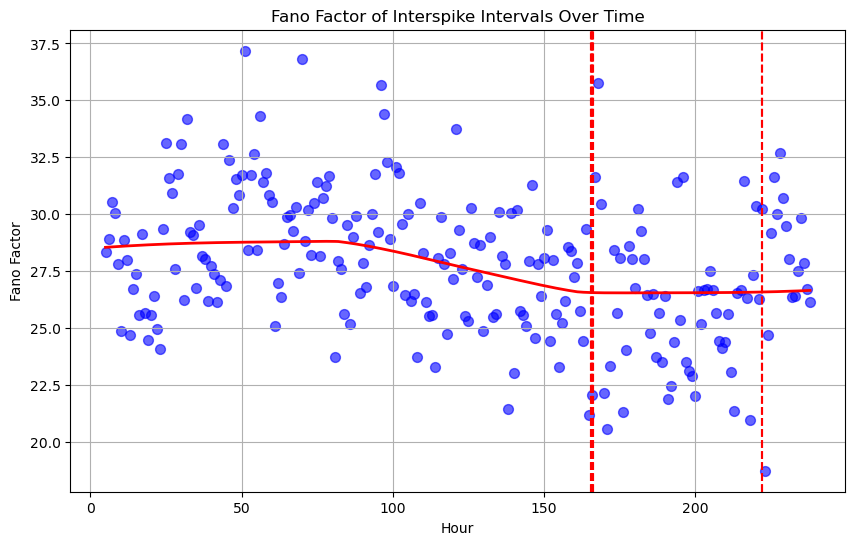

In [20]:
# Group by hour and compute variance and mean
fano_factor_grouped_df = filtered_df.groupby("hour")[
    "inter_spike_interval_samples"
].agg(["var", "mean"])

# Compute the Fano factor
fano_factor_grouped_df["fano_factor"] = (
    fano_factor_grouped_df["var"] / fano_factor_grouped_df["mean"]
)

# Plot the Fano factor over hours
plt.figure(figsize=(10, 6))

# Using seaborn to visualize the trend
sns.regplot(
    x=fano_factor_grouped_df.index,
    y=fano_factor_grouped_df["fano_factor"],
    lowess=True,
    scatter_kws={"s": 50, "alpha": 0.6},
    line_kws={"color": "red", "lw": 2},
    color="blue",
)

# Plot vertical lines indicating seizure times
for start, end in seizure_times_samples:
    plt.axvline(start / (fs * 3600), color="r", linestyle="--")
    plt.axvline(end / (fs * 3600), color="r", linestyle="--")

plt.xlabel("Hour")
plt.ylabel("Fano Factor")
plt.title("Fano Factor of Interspike Intervals Over Time")
plt.grid(True)
plt.show()

## Coefficient of variation as a function of mean interspike interval

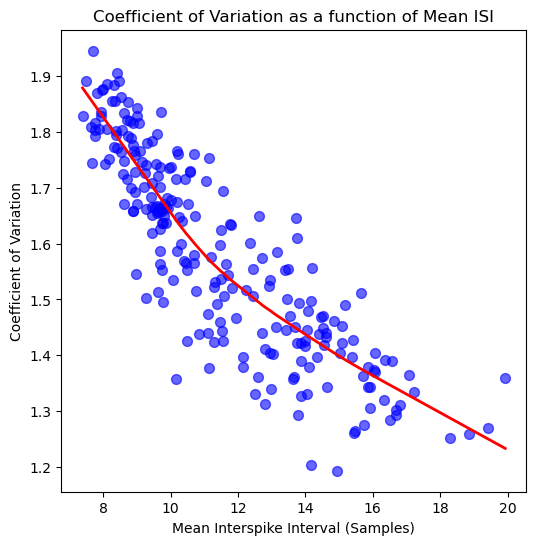

In [21]:
# Group by hour and compute standard deviation and mean
agg_data = filtered_df.groupby("hour")["inter_spike_interval_samples"].agg(
    ["std", "mean"]
)

# Compute the Coefficient of Variation
agg_data["CV"] = agg_data["std"] / agg_data["mean"]

# Plot the Coefficient of Variation as a function of the mean inter-spike interval
plt.figure(figsize=(6, 6))

sns.regplot(
    x=agg_data["mean"],
    y=agg_data["CV"],
    lowess=True,
    scatter_kws={"s": 50, "alpha": 0.6},
    line_kws={"color": "red", "lw": 2},
    color="blue",
)

plt.xlabel("Mean Interspike Interval (Samples)")
plt.ylabel("Coefficient of Variation")
plt.title("Coefficient of Variation as a function of Mean ISI")
plt.show()

## Cascade size distributions

In [22]:
# Group by sequence_index_mask and calculate the required columns
cascades_df = (
    filtered_df.groupby("sequence_index_mask")
    .agg(
        size=("sequence_index_mask", "size"),
        hour=("hour", lambda x: x.mode()[0] if not x.mode().empty else None),
    )
    .reset_index()
)
cascades_df

,sequence_index_mask,size,hour
0,1,2,5
1,2,2,5
2,3,2,5
3,4,2,5
4,5,3,5
...,...,...,...
73306,73307,16,238
73307,73308,1,238
73308,73309,3,238
73309,73310,1,238


In [23]:
def calculate_cascade_size_distribution(cascades_df):
    # Count occurrences of each size
    size_counts = cascades_df["size"].value_counts()

    # Calculate probabilities
    total_rows = len(cascades_df)
    probabilities = size_counts / total_rows

    # Return unique sizes and their corresponding probabilities
    return probabilities.index.values, probabilities.values

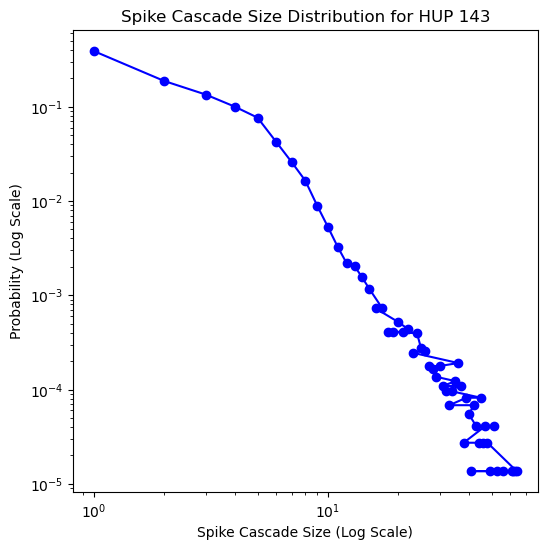

In [24]:
unique_sizes, probabilities = calculate_cascade_size_distribution(cascades_df)

# Log-transform the filtered data
log_unique_sizes = np.log(unique_sizes)
log_probabilities = np.log(probabilities)

# Plot the log-log scatter and the fit line
plt.figure(figsize=(6, 6))
plt.scatter(unique_sizes, probabilities, c="b")
plt.loglog(unique_sizes, probabilities, "b-", label="Data")
plt.title(f"Spike Cascade Size Distribution for HUP {patient_hup_id}")
plt.xlabel("Spike Cascade Size (Log Scale)")
plt.ylabel("Probability (Log Scale)")

plt.show()

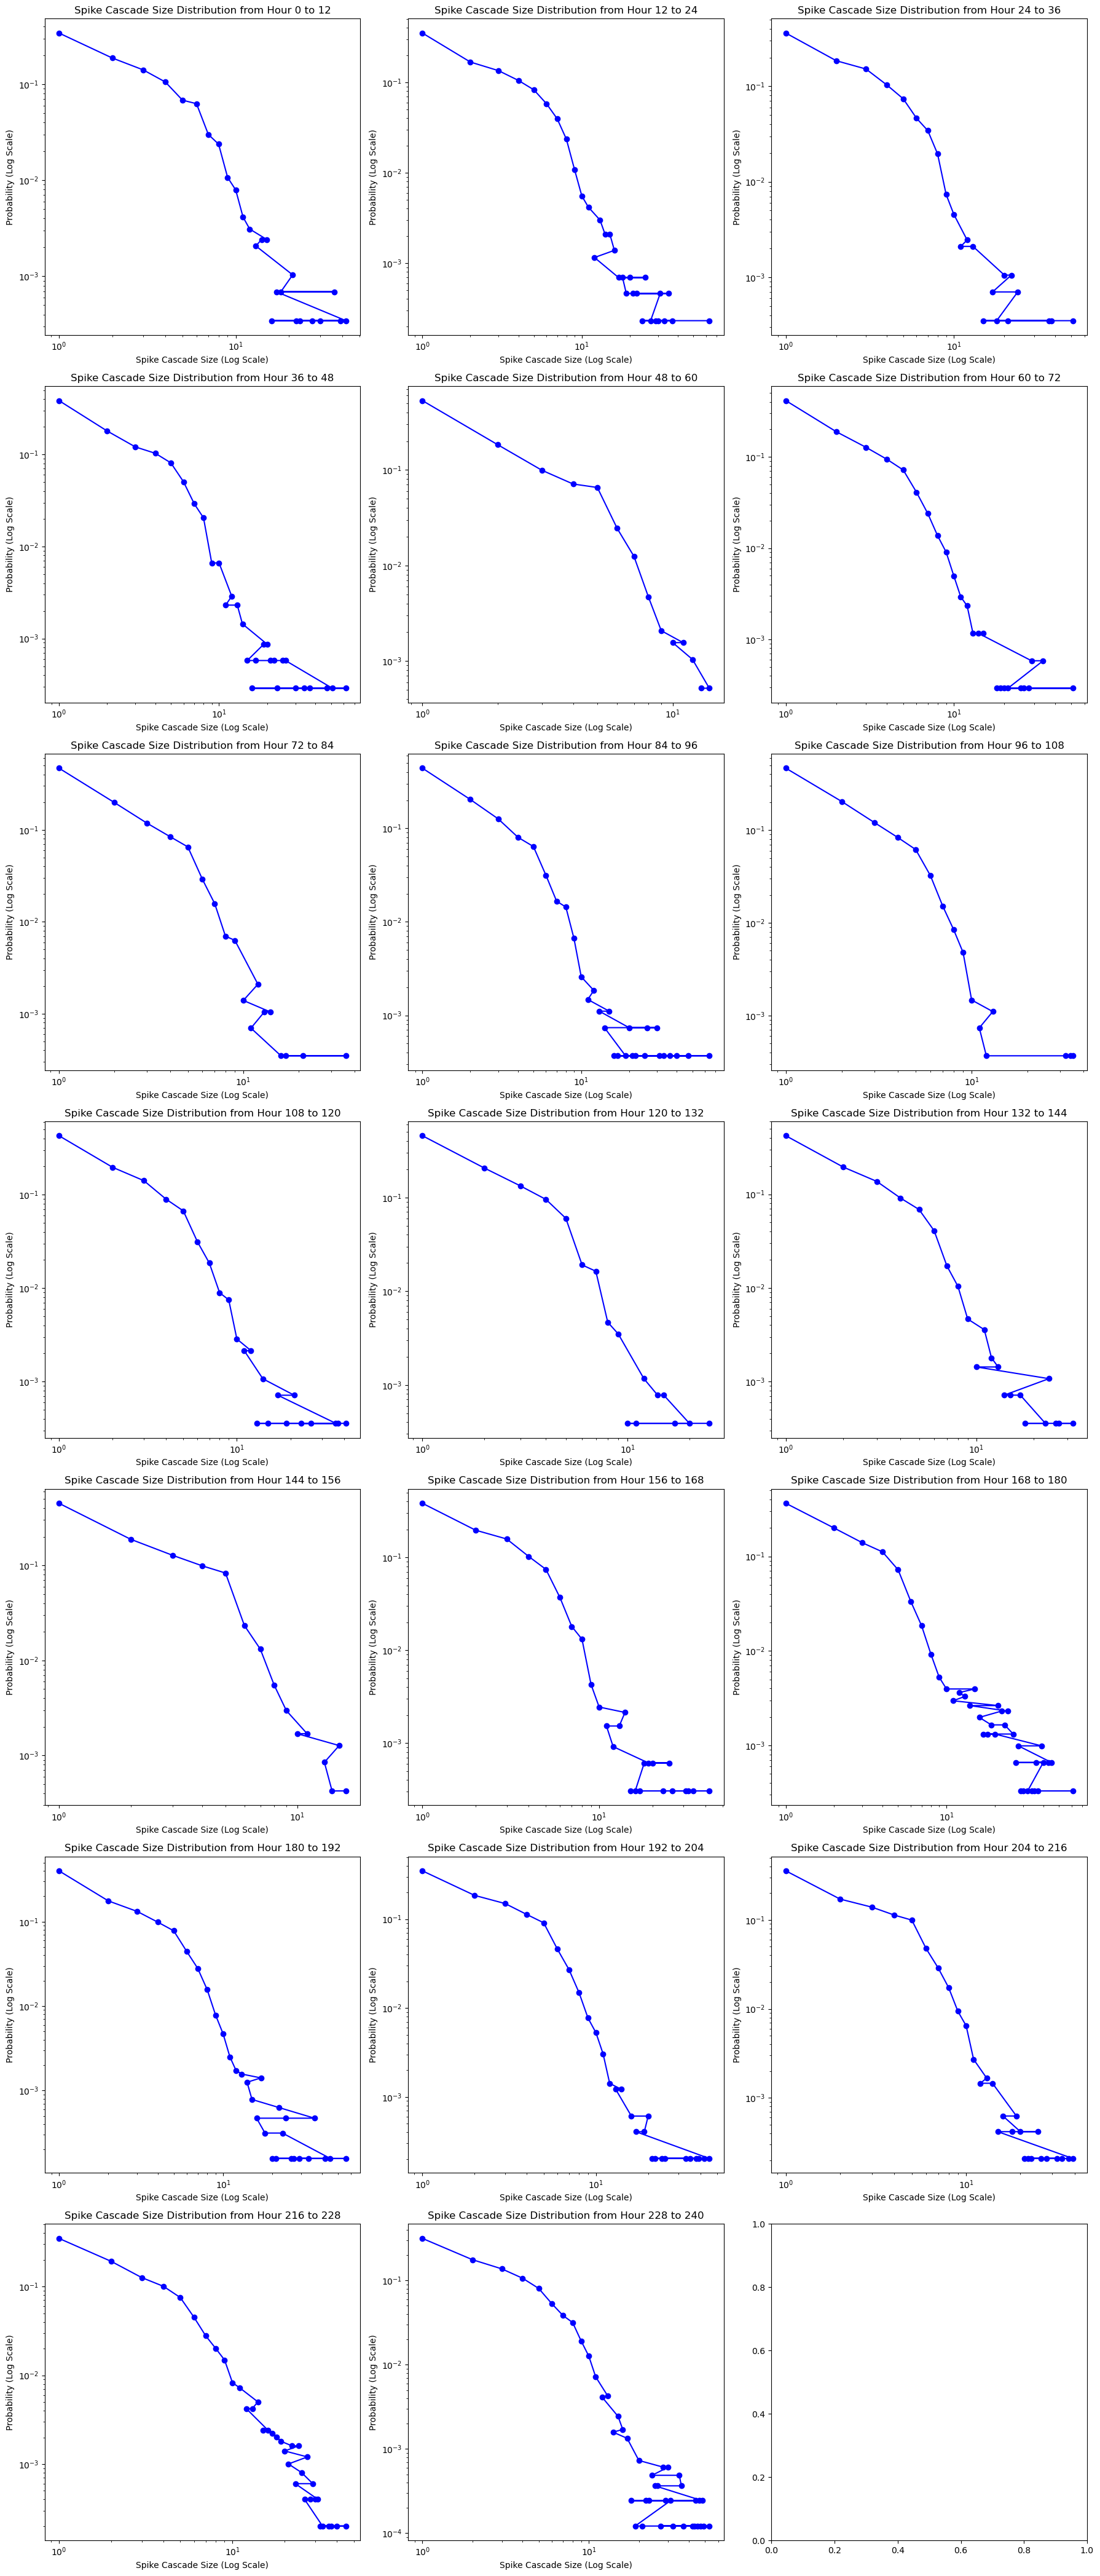

In [25]:
# Determine the number of unique 12-hour windows to determine the number of rows for subplots
num_windows = (cascades_df["hour"].max() // 12) + 1
num_rows = -(-num_windows // 3)  # This is a way to round up: num_windows divided by 3

fig, axs = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
current_row, current_col = 0, 0

# Split the data into 12-hour groups
for hour_start in range(0, cascades_df["hour"].max(), 12):
    hour_end = hour_start + 12
    subset_df = cascades_df[
        (cascades_df["hour"] >= hour_start) & (cascades_df["hour"] < hour_end)
    ]

    unique_sizes, probabilities = calculate_cascade_size_distribution(subset_df)

    # Skip if there's no data for this window
    if len(unique_sizes) == 0:
        continue

    # Log-transform the filtered data
    log_unique_sizes = np.log(unique_sizes)
    log_probabilities = np.log(probabilities)

    # Plot the log-log scatter and the fit line
    ax = axs[current_row, current_col]
    ax.scatter(unique_sizes, probabilities, c="b")
    ax.loglog(unique_sizes, probabilities, "b-", label="Data")
    ax.set_title(
        f"Spike Cascade Size Distribution from Hour {hour_start} to {hour_end}"
    )
    ax.set_xlabel("Spike Cascade Size (Log Scale)")
    ax.set_ylabel("Probability (Log Scale)")

    # Move to the next subplot
    current_col += 1
    if current_col > 2:
        current_col = 0
        current_row += 1

# Adjust layout
plt.tight_layout()
plt.show()

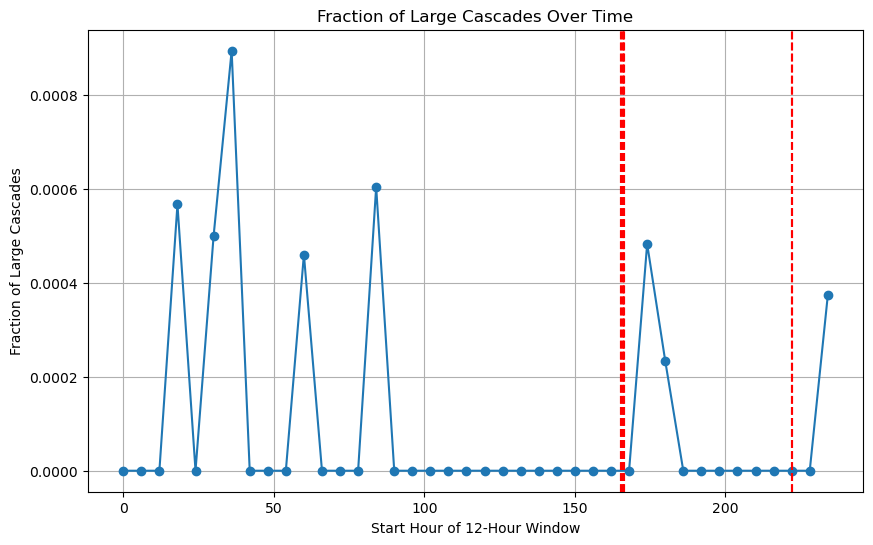

In [29]:
# Lists to hold our results
fractions = []
hours = []

# Split the data into 12-hour groups
for hour_start in range(0, cascades_df["hour"].max(), 6):
    hour_end = hour_start + 6
    subset_df = cascades_df[
        (cascades_df["hour"] >= hour_start) & (cascades_df["hour"] < hour_end)
    ]

    # Count the number of large cascades and total cascades
    num_large_cascades = len(subset_df[subset_df["size"] > 50])
    total_cascades = len(subset_df)

    # Avoid division by zero for empty subsets
    if total_cascades > 0:
        fraction = num_large_cascades / total_cascades
    else:
        fraction = 0

    # Append the results to our lists
    fractions.append(fraction)
    hours.append(hour_start)

# Plot the fractions over time
plt.figure(figsize=(10, 6))
plt.plot(hours, fractions, "-o")
# Plot vertical lines indicating seizure times
for start, end in seizure_times_samples:
    plt.axvline(start / (fs * 3600), color="r", linestyle="--")
    plt.axvline(end / (fs * 3600), color="r", linestyle="--")
plt.xlabel("Start Hour of 12-Hour Window")
plt.ylabel("Fraction of Large Cascades")
plt.title("Fraction of Large Cascades Over Time")
plt.grid()
plt.show()